# Keras Underfit Overfit


In [1]:
# Setup plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')


In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

spotify = pd.read_csv('./inputKaggle/spotify.csv')

X = spotify.copy().dropna()
y = X.pop('track_popularity')
artists = X['track_artist']

features_num = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms']
features_cat = ['playlist_genre']

preprocessor = make_column_transformer(
    (StandardScaler(), features_num),
    (OneHotEncoder(), features_cat),
)

# We'll do a "grouped" split to keep all of an artist's songs in one
# split or the other. This is to help prevent signal leakage.


def group_split(X, y, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])


X_train, X_valid, y_train, y_valid = group_split(X, y, artists)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
# popularity is on a scale 0-100, so this rescales to 0-1.
y_train = y_train / 100
y_valid = y_valid / 100

input_shape = [X_train.shape[1]]
print("Input shape: {}".format(input_shape))


INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2
Input shape: [18]


Minimum Validation Loss: 0.1971


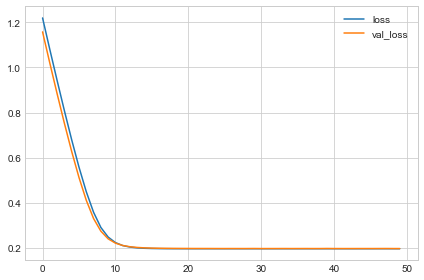

In [3]:
#Let's start with the simplest network, a linear model. This model has low capacity.
model = keras.Sequential([
    layers.Dense(1, input_shape=input_shape),
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    verbose=0,  # suppress output since we'll plot the curves
)
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))


Minimum Validation Loss: 0.1971


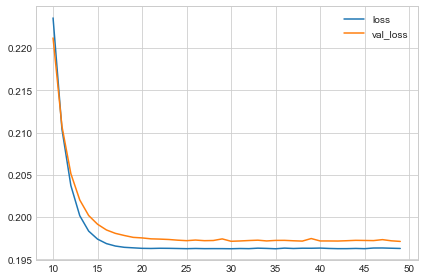

In [4]:
# Start the plot at epoch 10
history_df.loc[10:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))


Epoch 1/50
49/49 [==============================] - 1s 8ms/step - loss: 0.3354 - val_loss: 0.2147
Epoch 2/50
49/49 [==============================] - 0s 5ms/step - loss: 0.2322 - val_loss: 0.2132
Epoch 3/50
49/49 [==============================] - 0s 4ms/step - loss: 0.2184 - val_loss: 0.2092
Epoch 4/50
49/49 [==============================] - 0s 5ms/step - loss: 0.2124 - val_loss: 0.2043
Epoch 5/50
49/49 [==============================] - 0s 5ms/step - loss: 0.2086 - val_loss: 0.2057
Epoch 6/50
49/49 [==============================] - 0s 5ms/step - loss: 0.2046 - val_loss: 0.2029
Epoch 7/50
49/49 [==============================] - 0s 4ms/step - loss: 0.2030 - val_loss: 0.2022
Epoch 8/50
49/49 [==============================] - 0s 4ms/step - loss: 0.2006 - val_loss: 0.2018
Epoch 9/50
49/49 [==============================] - 0s 6ms/step - loss: 0.1998 - val_loss: 0.1992
Epoch 10/50
49/49 [==============================] - 0s 5ms/step - loss: 0.1982 - val_loss: 0.1989
Epoch 11/50
49/49 [

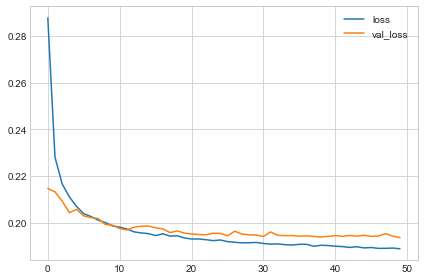

In [5]:
#Model is underfitting
#Let's add some capacity to our network. We'll add three hidden layers with 128 units each.
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))


In [6]:
# Now the validation loss begins to rise very early, while the training loss continues to decrease.
#  This indicates that the network has begun to overfit. 
# At this point, we would need to try something to prevent it, 
# either by reducing the number of units or through a method like early stopping.
#Now define an early stopping callback that waits 5 epochs(`patience'`) for a change in validation loss 
# of at least `0.001` (`min_delta`) and keeps the weights with the best loss(`restore_best_weights`).
from tensorflow.keras import callbacks

# YOUR CODE HERE: define an early stopping callback
early_stopping = callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)


Epoch 1/50
49/49 [==============================] - 0s 5ms/step - loss: 0.2771 - val_loss: 0.2070
Epoch 2/50
49/49 [==============================] - 0s 3ms/step - loss: 0.2042 - val_loss: 0.2027
Epoch 3/50
49/49 [==============================] - 0s 3ms/step - loss: 0.1949 - val_loss: 0.1999
Epoch 4/50
49/49 [==============================] - 0s 4ms/step - loss: 0.1936 - val_loss: 0.2031
Epoch 5/50
49/49 [==============================] - 0s 4ms/step - loss: 0.1926 - val_loss: 0.1990
Epoch 6/50
49/49 [==============================] - 0s 3ms/step - loss: 0.1890 - val_loss: 0.2007
Epoch 7/50
49/49 [==============================] - 0s 3ms/step - loss: 0.1894 - val_loss: 0.1983
Epoch 8/50
49/49 [==============================] - 0s 3ms/step - loss: 0.1861 - val_loss: 0.1994
Epoch 9/50
49/49 [==============================] - 0s 3ms/step - loss: 0.1843 - val_loss: 0.1985
Epoch 10/50
49/49 [==============================] - 0s 3ms/step - loss: 0.1846 - val_loss: 0.1999
Epoch 11/50
49/49 [

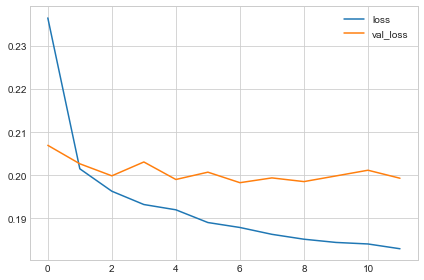

In [7]:
#Now run this cell to train the model and get the learning curves. 
# Notice the `callbacks` argument in `model.fit`.
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    callbacks=[early_stopping]
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))


In [8]:
# This was an improvement
#The early stopping callback did stop the training once the network began overfitting. 
# Moreover, by including restore_best_weights we still get to keep the model where validation loss 
# was lowest.
#If you like, try experimenting with `patience` and `min_delta` to see what difference it might make.
